In [10]:
# !pip install --upgrade ipywidgets

You should consider upgrading via the 'C:\Users\donha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()
# tqdm().pandas()

0it [00:00, ?it/s]

In [2]:
#load file text
def load_file(filename):
    with open(filename,'r') as f:
        text = f.read()
    return text

In [3]:
def all_img_captions(filename):
    file = load_file(filename)
    captions = file.split("\n") # tach tung dong
    descriptions = {}   
    for caption in captions[:-1]:   
        img, caption = caption.split("\t")   # chia thanh  imgpath va caption
        if img[:-2] not in descriptions:  # neu imgpath chua ton tai thi tao key = imgpath
            descriptions[img[:-2]] = [caption]
        else :
            descriptions[img[:-2]].append(caption) # append 
    return descriptions


In [4]:
def cleaning_text(descriptions):
    for img,captions in descriptions.items():
        for indx, caption in enumerate(captions):
            caption = caption.replace("-"," ")
            desc = caption.split() 
            desc = [word.lower() for word in desc] # chuyen ve chu thuong
            desc = [word.translate(str.maketrans('','',string.punctuation)) for word in desc] # xoa cac ki tu dac biet
            desc = [word for word in desc if(len(word)>1)] # xoa cac ki tu co do dai = 1
            desc = [word for word in desc if (word.isalpha())]  # xoa cac ki tu so

            caption = " " .join(desc) 
            descriptions[img][indx] = caption
    return descriptions



In [5]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(caption.split()) for caption in descriptions[key]]
    return vocab
    

In [6]:
def save_descriptions(descriptions,filename):
    lines = list()
    for img,captions in descriptions.items():
        for caption in captions:
            lines.append(img + "\t" + caption )
    data = "\n".join(lines)
    with open(filename,'w') as f :
        f.write(data)
    

In [7]:
descriptions = all_img_captions("./Flicker8k_Text/Flickr8k.token.txt")
descriptions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [8]:
clean_descriptions = cleaning_text(descriptions)
clean_descriptions

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young

In [9]:
vocab = text_vocabulary(clean_descriptions)
vocab

{'crooked',
 'teaches',
 'leave',
 'rising',
 'within',
 'atheletes',
 'reflected',
 'grate',
 'collection',
 'opened',
 'identification',
 'beaked',
 'ships',
 'shines',
 'vista',
 'tattoo',
 'fires',
 'slam',
 'waterway',
 'lays',
 'dunking',
 'library',
 'cones',
 'intertube',
 'substance',
 'rafter',
 'note',
 'shrubbery',
 'boarder',
 'picnickers',
 'by',
 'anything',
 'encircling',
 'joined',
 'canvasses',
 'bottles',
 'preservers',
 'chow',
 'snowpacked',
 'driver',
 'heard',
 'whiffle',
 'heads',
 'biscut',
 'posign',
 'fedex',
 'lack',
 'fighter',
 'breakdancer',
 'sang',
 'lightsaber',
 'dial',
 'rotary',
 'pigeon',
 'position',
 'welcome',
 'pokemon',
 'falling',
 'parade',
 'asia',
 'naval',
 'informal',
 'ou',
 'htting',
 'ot',
 'hapily',
 'floppy',
 'paraphernalia',
 'reptiles',
 'worm',
 'lab',
 'climbs',
 'clowning',
 'newborn',
 'striding',
 'hamburgers',
 'kneeled',
 'unfinished',
 'dreeds',
 'noticable',
 'runway',
 'outfir',
 'herding',
 'caterpillar',
 'enough',
 '

In [10]:
len(vocab)

8422

In [25]:
save_descriptions(clean_descriptions, "descriptions.txt")

In [205]:
def extract_features(directory):
    model = InceptionV3( include_top=False, pooling='avg' )
    features= {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + '/' + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image,axis=0)
        image = image/255.

        feature = model.predict(image)
        features[img] = feature
#     return features

features = extract_features("./Flicker8k_Dataset/")


87910968/87910968 [==============================] - 12s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 221ms/step


1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 226ms/step


1/1 [==============================] - 0s 232ms/step


In [21]:
features['1000268201_693b08cb0e.jpg']

array([[0.38933668, 0.02498299, 0.15158135, ..., 0.17057139, 0.0063863 ,
        0.19085081]], dtype=float32)

In [10]:
# dump(features, open("features.p","wb"))

In [11]:
dump(features, open("features_InceptionV3.p","wb"))

NameError: name 'features' is not defined

In [12]:
features = load(open("features_InceptionV3.p",'rb'))

In [13]:
def load_images(filename):
    file = load_file(filename)
    images = file.split("\n")[:-1]
    return images


In [14]:
def load_clean_descriptions(filename,images):
    # load clean_descriptions 
    captions = load_file(filename)
    descriptions = {}
    for caption in captions.split("\n"):
        words = caption.split()
        if len(words) < 1: 
            continue
        image, caption = words[0],words[1:]
        if image in images:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start>' + " ".join(caption) + '<end>'
            descriptions[image].append(desc)
    return descriptions

In [15]:
def load_features(images):
    all_features = load(open("features_InceptionV3.p",'rb'))
    features = {k:all_features[k] for k in all_features}
    return features

In [16]:
train_imgs = load_images("./Flicker8k_Text/Flickr_8k.trainImages.txt")
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [17]:
train_descriptions = load_clean_descriptions("./descriptions.txt",train_imgs)
train_descriptions

{'1000268201_693b08cb0e.jpg': ['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
  '<start>girl going into wooden building<end>',
  '<start>little girl climbing into wooden playhouse<end>',
  '<start>little girl climbing the stairs to her playhouse<end>',
  '<start>little girl in pink dress going into wooden cabin<end>'],
 '1001773457_577c3a7d70.jpg': ['<start>black dog and spotted dog are fighting<end>',
  '<start>black dog and tri colored dog playing with each other on the road<end>',
  '<start>black dog and white dog with brown spots are staring at each other in the street<end>',
  '<start>two dogs of different breeds looking at each other on the road<end>',
  '<start>two dogs on pavement moving toward each other<end>'],
 '1002674143_1b742ab4b8.jpg': ['<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl<end>',
  '<start>little girl is sitting in front of large painted rainbow<end>',
  '<start>small girl in the gra

In [18]:
train_features = load_features(train_imgs)
train_features

{'1000268201_693b08cb0e.jpg': array([[0.11328506, 0.15111764, 0.7328588 , ..., 0.16666302, 0.40616015,
         0.43842983]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.7394507 , 0.5261144 , 0.15619549, ..., 0.02817826, 0.6911025 ,
         1.1200845 ]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[0.31327984, 0.09859151, 0.7064929 , ..., 1.0421717 , 0.3184309 ,
         0.01311949]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.42254663, 0.40813968, 0.42933926, ..., 1.0788656 , 0.3835814 ,
         0.24775699]], dtype=float32),
 '1007129816_e794419615.jpg': array([[0.17669216, 0.14747216, 0.22247663, ..., 0.4327008 , 0.3926713 ,
         0.26266867]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.3588996 , 0.4666215 , 0.1663919 , ..., 0.08306666, 1.2417374 ,
         0.63907546]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.47577912, 1.3472484 , 1.2577097 , ..., 0.3449253 , 0.53589976,
         0.52082455]], dtype=float32),
 '1012

In [19]:
def dict_to_list(descriptions):
    all_desc = []
    for image in descriptions.keys():
        [all_desc.append(caption) for caption in descriptions[image]]
    return all_desc
        

In [20]:
def create_tokenizer(descriptions):
    all_desc = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc)
    return tokenizer
    
    

In [254]:
tokenizer = create_tokenizer(descriptions)
dump(tokenizer,open('tokenizer.p','wb'))


In [21]:
tokenizer = load(open("tokenizer.p",'rb'))

In [22]:
vocab_len = len(tokenizer.word_index)+1
vocab_len

8423

In [23]:
def max_length(descriptions):
    all_desc = dict_to_list(descriptions)
    max_len = max(len(captions.split()) for captions in all_desc)
    return max_len
max_len = max_length(descriptions)
max_len

33

In [24]:
tokenizer.index_word

{1: 'in',
 2: 'the',
 3: 'on',
 4: 'is',
 5: 'and',
 6: 'dog',
 7: 'with',
 8: 'man',
 9: 'of',
 10: 'two',
 11: 'white',
 12: 'black',
 13: 'boy',
 14: 'are',
 15: 'woman',
 16: 'girl',
 17: 'to',
 18: 'wearing',
 19: 'at',
 20: 'people',
 21: 'water',
 22: 'red',
 23: 'young',
 24: 'brown',
 25: 'an',
 26: 'his',
 27: 'blue',
 28: 'dogs',
 29: 'running',
 30: 'through',
 31: 'playing',
 32: 'while',
 33: 'shirt',
 34: 'down',
 35: 'standing',
 36: 'ball',
 37: 'little',
 38: 'grass',
 39: 'snow',
 40: 'child',
 41: 'person',
 42: 'jumping',
 43: 'over',
 44: 'three',
 45: 'front',
 46: 'sitting',
 47: 'holding',
 48: 'up',
 49: 'field',
 50: 'small',
 51: 'by',
 52: 'large',
 53: 'green',
 54: 'one',
 55: 'group',
 56: 'yellow',
 57: 'her',
 58: 'walking',
 59: 'children',
 60: 'men',
 61: 'into',
 62: 'air',
 63: 'beach',
 64: 'near',
 65: 'mouth',
 66: 'jumps',
 67: 'another',
 68: 'for',
 69: 'street',
 70: 'runs',
 71: 'its',
 72: 'from',
 73: 'riding',
 74: 'stands',
 75: 'as',


In [25]:
def data_generator(descriptions,features,tokenizer,max_len):
    while(True):
        for key,captions in descriptions.items():
            feature = features[key][0]
            input_img, input_sequence, output_word = create_sequence(tokenizer,max_len,captions,feature) 
            yield [[input_img,input_sequence],output_word]

In [26]:
def create_sequence(tokenizer,max_len,captions,feature):
    X1, X2, y = list(), list(), list()
    for caption in captions : 
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
            #split into input, output pair
            in_seq, out_seq = seq[:i],seq[i]
            #padding 
            in_seq = pad_sequences([in_seq],maxlen=max_len)[0]
            #encoding output
            out_seq = to_categorical([out_seq],num_classes=vocab_len)[0]
            
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

            

In [27]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_len))
a.shape, b.shape, c.shape

((47, 2048), (47, 33), (47, 8423))

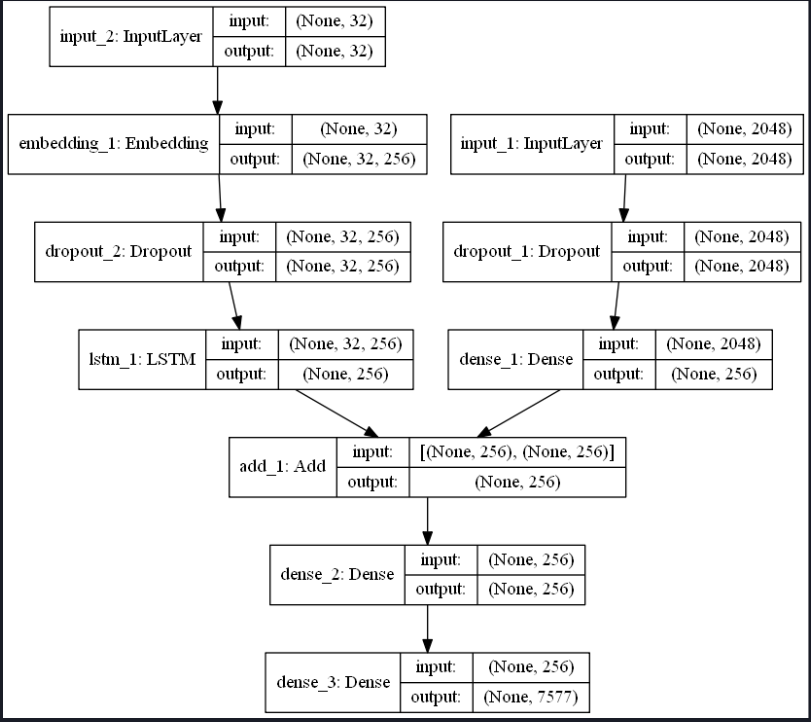

In [258]:
def create_model(vocab_size,max_len):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256,activation='relu')(fe1)
    
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    decoder1 = Add()([fe2,se3])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(vocab_size,activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1,inputs2],outputs = outputs)
    return model

In [259]:
vocab_len

8423

In [61]:
model  = create_model(vocab_len,max_len)

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 33, 256)      2156288     ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                              

In [63]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam')

In [ ]:
steps = len(train_descriptions)
epochs = 10

os.mkdir("models_InceptionV3")
for i in range(epochs):
    generator = data_generator(train_descriptions,train_features,tokenizer,max_len)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save("models_InceptionV3/model_" +str(i)+".h5")

C:\Users\donha\AppData\Local\Temp\ipykernel_18732\1511196933.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


5361/6000 [=========================>....] - ETA: 5:10 - loss: 2.9018

In [69]:
!pip install argparse

In [28]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)

    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for images that has 4 channels, we convert them into 3 channels
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

In [29]:
def word_index(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [30]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence = np.array(sequence)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_index(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [44]:
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('./models_InceptionV3/model_3.h5')

In [45]:
xception_model = InceptionV3(include_top=False, pooling="avg")

In [52]:
path = "./Flicker8k_Dataset/1131800850_89c7ffd477.jpg"

1/1 [==============================] - 0s 114ms/step



start dog is running through the water end


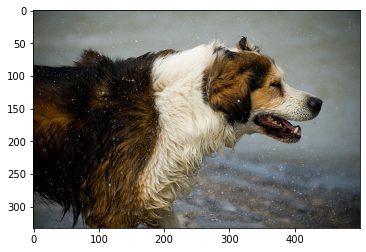

In [53]:
import matplotlib.pyplot as plt
image = extract_features(path, xception_model)
img = Image.open(path)

description = generate_desc(model, tokenizer, image, max_len)
print("\n\n")
print(description)
plt.imshow(img)